In [1]:
# !pip install scipy numpy matplotlib scikit-image

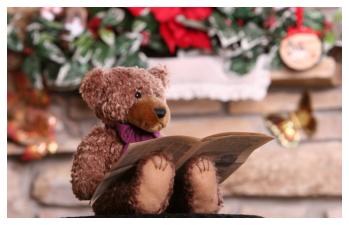

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load an image from file (replace 'path/to/your/image.jpg' with the actual path)
image_path = './input0.png'
img = mpimg.imread(image_path)

# Plot the image
plt.imshow(img)

#set axis off
plt.axis('off')

# Display the plot
plt.show()


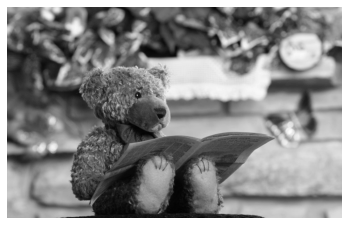

In [71]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load an image from file (replace 'path/to/your/image.jpg' with the actual path)
img = mpimg.imread(image_path)

# Convert the image to grayscale
gray_img = np.dot(img[..., :3], [0.299, 0.587, 0.114])

# Plot the grayscale image
plt.imshow(gray_img, cmap='gray')

# Save the grayscale image
gray_image_path = './gray.jpg'
plt.imsave(gray_image_path, gray_img, cmap='gray')
plt.axis('off')
# Display the plot
plt.show()


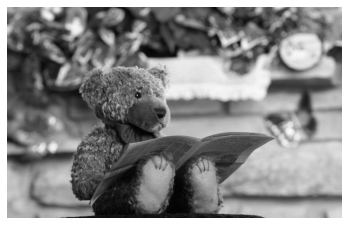

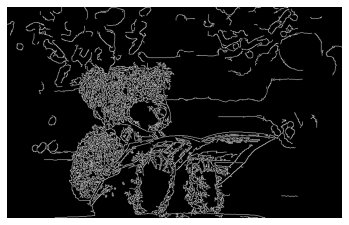

In [73]:
import cv2
# from google.colab.patches import cv2_imshow

img = cv2.imread("./gray.jpg")  # Read image

# Setting parameter values
t_lower = 30  # Lower Threshold
t_upper = 170  # Upper threshold

# Applying the Canny Edge filter
edge = cv2.Canny(img, t_lower, t_upper)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.show()
plt.axis('off')
plt.imshow(edge, cmap='gray')
plt.show()
# cv2_imshow(img)
# cv2_imshow(edge)

## 1. Sparse Defocus Map

### Intensity map

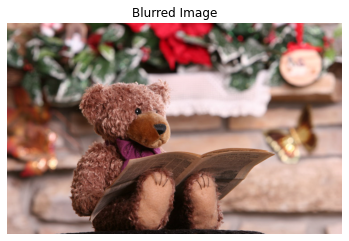

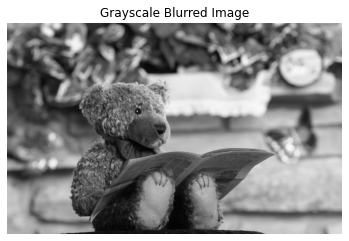

In [5]:
import cv2
import matplotlib.pyplot as plt

def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

img = cv2.imread(image_path)
show_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'Blurred Image')

blurred_intensity_map = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image(blurred_intensity_map, 'Grayscale Blurred Image')

### edge detection

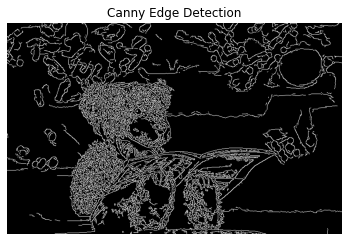

In [6]:
edge = cv2.Canny(blurred_intensity_map, 30, 100)
edge = edge.astype(np.float32)
edge /= 255.
show_image(edge, 'Canny Edge Detection', cmap_type='gray')

### normalization

In [7]:
blurred_intensity_map = blurred_intensity_map.astype(np.float32)
blurred_intensity_map /= 255.

### reblurred image

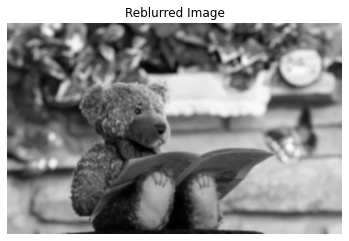

In [8]:
reblur_sigma = 1.5
reblurred_intensity_map = cv2.GaussianBlur(blurred_intensity_map, (0, 0), reblur_sigma)
show_image(reblurred_intensity_map, 'Reblurred Image')

In [9]:
assert reblurred_intensity_map.max() <= 1.0
assert reblurred_intensity_map.min() >= 0.0
assert blurred_intensity_map.max() <= 1.0
assert blurred_intensity_map.min() >= 0.0

### gradient magnitude

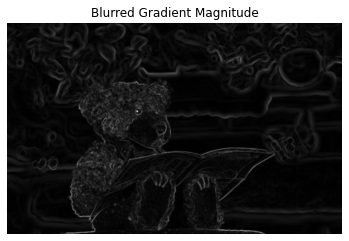

In [10]:
blurred_gradient_x = cv2.Sobel(blurred_intensity_map, cv2.CV_32F, 1, 0, ksize=3)
blurred_gradient_y = cv2.Sobel(blurred_intensity_map, cv2.CV_32F, 0, 1, ksize=3)
blurred_gradient_magnitude = cv2.magnitude(blurred_gradient_x, blurred_gradient_y)
blurred_gradient_magnitude = cv2.medianBlur(blurred_gradient_magnitude, 3)
show_image(blurred_gradient_magnitude, 'Blurred Gradient Magnitude', cmap_type='gray')

### reblurred gradient

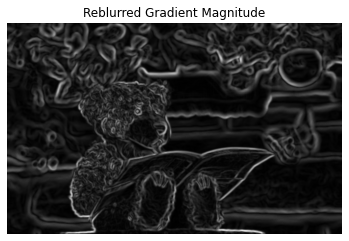

In [11]:
reblurred_gradient_x = cv2.Sobel(reblurred_intensity_map, cv2.CV_32F, 1, 0, ksize=3)
reblurred_gradient_y = cv2.Sobel(reblurred_intensity_map, cv2.CV_32F, 0, 1, ksize=3)
reblurred_gradient_magnitude = cv2.magnitude(reblurred_gradient_x, reblurred_gradient_y)
reblurred_gradient_magnitude = cv2.medianBlur(reblurred_gradient_magnitude, 3)
show_image(reblurred_gradient_magnitude, 'Reblurred Gradient Magnitude', cmap_type='gray')

In [12]:
reblurred_gradient_magnitude.max()

1.1471214

### sparse defocus map

In [13]:
sparse_defocus_dict = {}
sparse_defocus_map = np.zeros_like(edge)
bad_count = 0
good_count = 0
for i in range(edge.shape[0]):
    for j in range(edge.shape[1]):
        if edge[i, j] == 1.0:
            R = blurred_gradient_magnitude[i, j] / reblurred_gradient_magnitude[i, j]
            if R <= 1:
                bad_count += 1
            else:
                good_count += 1
                sigma = reblur_sigma / np.sqrt(R**2 - 1)
                sparse_defocus_dict[(i, j)] = sigma
                sparse_defocus_map[i, j] = sigma
        else:
            sparse_defocus_map[i, j] = np.nan
print(bad_count)
print(good_count)

652
36624


### joint bilateral filter

In [14]:
# # perform joint bilateral filtering on gradient_ratio
# sigma_s = 5
# sigma_r = 0.3
# filtered_gradient_ratio = cv2.ximgproc.jointBilateralFilter(sparse_defocus_map, sparse_defocus_map, -1, sigma_s, sigma_r)
# show_image(filtered_gradient_ratio, 'Filtered Gradient Ratio', cmap_type='gray')

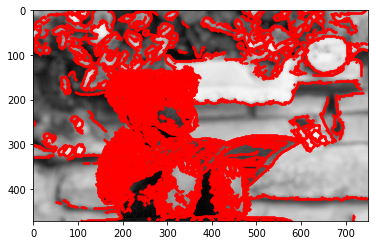

In [15]:
plt.imshow(blurred_intensity_map, cmap='gray')
plt.scatter(*zip(*[ (j, i) for (i, j) in sparse_defocus_dict.keys()]), color='r', s=1)
plt.show()

### matting laplacian

In [20]:
import cv2
import numpy as np
import scipy.ndimage
import scipy.sparse
import scipy.sparse.linalg


from skimage import feature


def make_system(L, sparse_map, constraint_factor=0.001):
    spflatten = sparse_map.ravel()
    D = scipy.sparse.diags(spflatten)
    A = constraint_factor * D + L
    b = constraint_factor * D * spflatten
    return A, b


def g1x(x, y, s1):
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(x, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


def g1y(x, y, s1):
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(y, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


def get_laplacian(I, r=1):
    eps = 0.0000001
    h, w, c = I.shape
    wr = (2 * r + 1) * (2 * r + 1)

    M_idx = np.arange(h * w).reshape(w, h).T
    n_vals = (w - 2 * r) * (h - 2 * r) * wr ** 2

    row_idx = np.zeros(n_vals, dtype=np.int64)
    col_idx = np.zeros(n_vals, dtype=np.int64)
    vals = np.zeros(n_vals, dtype=np.float64)
    lenr = 0

    for j in range(r, h - r):
        for i in range(r, w - r):
            winr = I[j - r:j + r + 1, i - r:i + r + 1, 2]
            wing = I[j - r:j + r + 1, i - r:i + r + 1, 1]
            winb = I[j - r:j + r + 1, i - r:i + r + 1, 0]
            win_idx = M_idx[j - r:j + r + 1, i - r:i + r + 1].T.ravel()

            meanwinr = winr.mean()
            winrsq = np.multiply(winr, winr)
            varI_rr = winrsq.sum() / wr - meanwinr ** 2

            meanwing = wing.mean()
            wingsq = np.multiply(wing, wing)
            varI_gg = wingsq.sum() / wr - meanwing ** 2

            meanwinb = winb.mean()
            winbsq = np.multiply(winb, winb)
            varI_bb = winbsq.sum() / wr - meanwinb ** 2

            winrgsq = np.multiply(winr, wing)
            varI_rg = winrgsq.sum() / wr - meanwinr * meanwing

            winrbsq = np.multiply(winr, winb)
            varI_rb = winrbsq.sum() / wr - meanwinr * meanwinb

            wingbsq = np.multiply(wing, winb)
            varI_gb = wingbsq.sum() / wr - meanwing * meanwinb

            Sigma = np.array([[varI_rr, varI_rg, varI_rb],
                              [varI_rg, varI_gg, varI_gb],
                              [varI_rb, varI_gb, varI_bb]])

            meanI = np.array([meanwinr, meanwing, meanwinb])

            Sigma = Sigma + eps * np.eye(3)

            winI = np.zeros((wr, c))

            winI[:, 0] = winr.T.ravel()
            winI[:, 1] = wing.T.ravel()
            winI[:, 2] = winb.T.ravel()

            winI = winI - meanI

            inv_cov = np.linalg.inv(Sigma)
            tvals = (1 + np.matmul(np.matmul(winI, inv_cov), winI.T)) / wr

            row_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (1, wr)).ravel()
            col_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (wr, 1)).T.ravel()
            vals[lenr:wr ** 2 + lenr] = tvals.T.ravel()

            lenr += wr ** 2

    Lsparse = scipy.sparse.coo_matrix((vals, (row_idx, col_idx)), shape=(w * h, w * h))

    row_idx2 = np.zeros(w * h, dtype=np.int64)
    col_idx2 = np.zeros(w * h, dtype=np.int64)
    vals2 = np.zeros(w * h, dtype=np.float64)

    row_idx2[:] = np.arange(w * h)
    col_idx2[:] = np.arange(w * h)
    vals2[:] = Lsparse.sum(axis=1).ravel()

    LDsparse = scipy.sparse.coo_matrix((vals2, (row_idx2, col_idx2)), shape=(w * h, w * h))

    return LDsparse - Lsparse



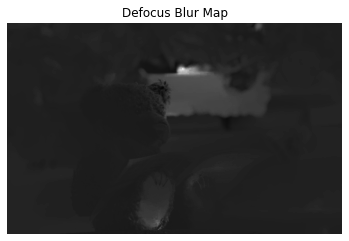

In [21]:
sparse_bmap = sparse_defocus_map.copy()
sparse_bmap[np.isnan(sparse_bmap)] = 0
h, w = sparse_bmap.shape
img = cv2.imread(image_path)
L1 = get_laplacian(img / 255.0)
A, b = make_system(L1, sparse_bmap.T)
bmap = scipy.sparse.linalg.spsolve(A, b).reshape(w, h).T

show_image(bmap, 'Defocus Blur Map', cmap_type='gray')

Now we try this with another method to see if we can improve this

In [22]:
def estimate_sparse_blur(gimg, edge_map, std1, std2):
    
    half_window = 11
    m = half_window * 2 + 1
    a = np.arange(-half_window, half_window + 1)
    xmesh = np.tile(a, (m, 1))
    ymesh = xmesh.T

    f11 = g1x(xmesh, ymesh, std1)
    f12 = g1y(xmesh, ymesh, std1)

    f21 = g1x(xmesh, ymesh, std2)
    f22 = g1y(xmesh, ymesh, std2)

    gimx1 = scipy.ndimage.convolve(gimg, f11, mode='nearest')
    gimy1 = scipy.ndimage.convolve(gimg, f12, mode='nearest')
    mg1 = np.sqrt(gimx1 ** 2 + gimy1 ** 2)

    gimx2 = scipy.ndimage.convolve(gimg, f21, mode='nearest')
    gimy2 = scipy.ndimage.convolve(gimg, f22, mode='nearest')
    mg2 = np.sqrt(gimx2 ** 2 + gimy2 ** 2)

    R = np.divide(mg1, mg2)
    R = np.multiply(R, edge_map > 0)

    sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2)
    sparse_vals[sparse_vals < 0] = 0

    sparse_bmap = np.sqrt(sparse_vals)
    sparse_bmap[np.isnan(sparse_bmap)] = 0
    sparse_bmap[sparse_bmap > 5] = 5

    return sparse_bmap


def estimate_bmap_laplacian(img, sigma_c, std1, std2):

    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
    edge_map = feature.canny(gimg, sigma_c)

    sparse_bmap = estimate_sparse_blur(gimg, edge_map, std1, std2)
    h, w = sparse_bmap.shape

    L1 = get_laplacian(img / 255.0)
    A, b = make_system(L1, sparse_bmap.T)

    bmap = scipy.sparse.linalg.spsolve(A, b).reshape(w, h).T

    return bmap

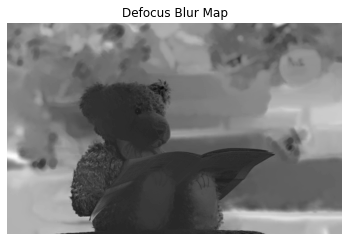

In [23]:
img = cv2.imread("./input0.png")
fblurmap = estimate_bmap_laplacian(img, sigma_c = 1, std1 = 1, std2 = 1.5)
normalized_fblurmap = np.uint8((fblurmap / fblurmap.max()) * 255)
cv2.imwrite("./input0" + '_bmap.png', normalized_fblurmap)

show_image(normalized_fblurmap, 'Defocus Blur Map', cmap_type='gray')

np.save("./input0" + '_bmap.npy', fblurmap)

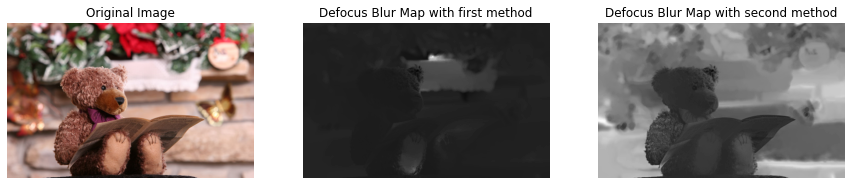

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image')
ax[0].axis('off')  
ax[1].imshow(bmap, cmap='gray')
ax[1].set_title('Defocus Blur Map with first method')
ax[1].axis('off')
ax[2].imshow(normalized_fblurmap, cmap='gray')
ax[2].set_title('Defocus Blur Map with second method')
ax[2].axis('off')
plt.show()

So we decide to go with the second method since we intuitively recognize that the second method is separating foreground and background in a better way.

(472, 750)


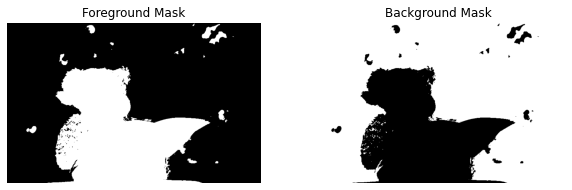

In [68]:
print(normalized_fblurmap.shape)
threshold = 110
foreground_mask = np.zeros_like(normalized_fblurmap)
foreground_mask[normalized_fblurmap < threshold] = 255
cv2.imwrite("./input0" + '_foreground.png', foreground_mask)
background_mask = np.zeros_like(normalized_fblurmap)
background_mask[normalized_fblurmap >= threshold] = 255
cv2.imwrite("./input0" + '_background.png', background_mask)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(foreground_mask, cmap='gray')
ax[0].set_title('Foreground Mask')
ax[0].axis('off')
ax[1].imshow(background_mask, cmap='gray')
ax[1].set_title('Background Mask')
ax[1].axis('off')
plt.show()




We found an approperiate threshold for detecting foreground and background

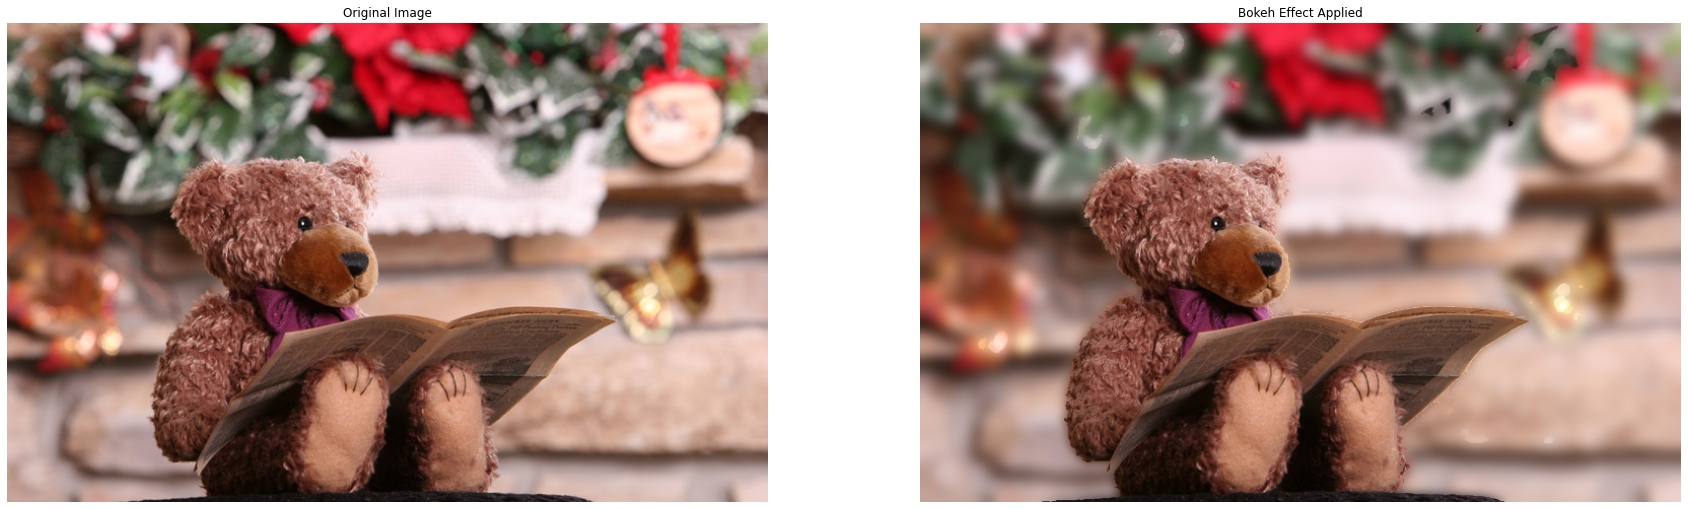

In [69]:
#result = Blur(img) * B + img * F
bokeh_sigma=5
kernel_size = 6*bokeh_sigma+1
background = cv2.merge((background_mask,background_mask,background_mask))
foreground = cv2.merge((foreground_mask,foreground_mask,foreground_mask))
img= cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)/255

bokeh = (cv2.GaussianBlur(img, (kernel_size, kernel_size), bokeh_sigma) * background / 255) + (img * foreground / 255)

ax , fig = plt.subplots(1, 2, figsize=(30, 10))
fig[0].imshow(img)
fig[0].set_title('Original Image')
fig[0].axis('off')
fig[1].imshow(bokeh)
fig[1].set_title('Bokeh Effect Applied')
fig[1].axis('off')
plt.show()



And here's the result for bokeh effect as you see in the result the background is blurred successfully and the foreground is the same as in original picture